# Set up the matrix

In [1]:
import sys
sys.executable

'C:\\Users\\KarlKristian\\Anaconda3\\envs\\numfys\\python.exe'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from walker import *
from grid import *
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
import scipy.sparse.linalg as lg
from numba import jit
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from dask import delayed, compute
import matplotlib.path as mplpath

In [30]:
# g = 5 # recursion depth
# pts = 0 # points between each corner of the fractal
# %time position_dict = koch_walker(depth=g, points_between=pts)
# save_grid(position_dict, g, pts)

Wall time: 39.7 s


Load grid

In [16]:
#p0 = load_grid(0,0)
#p1 = load_grid(1,0)
p2 = load_grid(2, 0)
p3 = load_grid(3,0)
p4 = load_grid(4, 0)

TypeError: load_grid() takes 1 positional argument but 2 were given

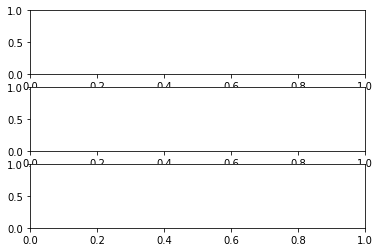

In [15]:

fig, axs = plt.subplots(nrows=3, ncols=1)
    for ax in axs:
        

In [4]:
%time position_dict = load_grid(4, 0)

Wall time: 8.98 ms


In [5]:
pos_list = np.array(list(position_dict))
max_idx = normalize(pos_list)
%time normalized_dict = {tuple(p):True for p in pos_list}
max_idx

Wall time: 25 ms


426

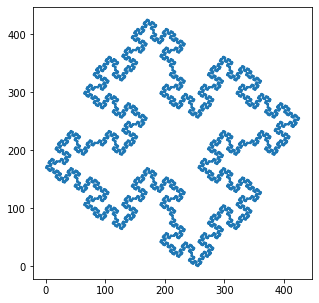

In [6]:
fig = plt.figure(figsize=(5,5))
plt.plot(*zip(*pos_list))

## point inside?
---
### matplotlib.path

In [7]:
path=mplpath.Path(pos_list)

In [8]:
points = np.random.randint(0, high =max_idx, size = (max_idx**2,2))

In [9]:
points.shape

(181476, 2)

In [10]:
%time path.contains_points(points)

Wall time: 18 s


array([ True,  True, False, ..., False, False, False])

In [10]:
fractal = np.zeros((max_idx,max_idx))

In [11]:
all_points = np.array([(i,j) for i in range(max_idx) for j in range(max_idx)])
all_points.shape

(181476, 2)

In [12]:
%time contains = path.contains_points(all_points).reshape((max_idx, max_idx))
%time fractal[contains] += 1

Wall time: 16.2 s
Wall time: 0 ns


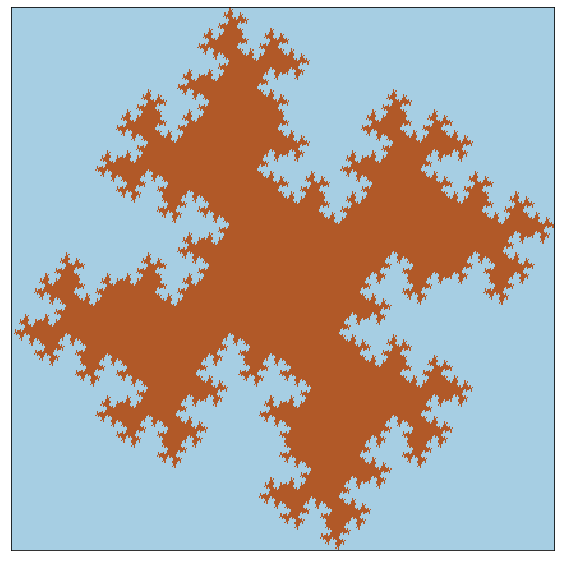

In [190]:
fig = plt.figure(figsize = (10,10))
plt.imshow(fractal, cmap="Paired")
# plt.(all_points)
plt.xticks([])
plt.yticks([])
plt.savefig(f"fractal_{4}_{0}.png")

### shapely

In [15]:
%time polygon = Polygon(pos_list)
%time contains = [Point(point).within(polygon) for point in points[0:2000]]

#contains = [Polygon.contains(point) for point in testpoints]

Wall time: 969 µs
Wall time: 21.5 s


### Ray tracing

In [191]:
def ray_tracing(point, pos_dict, max_idx):
    """
    Should add support for dictionary containing all previously found points.
    """
    if pos_dict.get(tuple(point), False):
        return True
    
    #sign = 1
    x0, y0 = point
    
    a = np.min([abs(max_idx-x0), x0])
    b = np.min([abs(max_idx-y0), y0])
    if a<b:
        idx=0
    else: 
        idx=1
    
    sign = np.sign(point[idx]-max_idx//2)
    
    p = list(point)
    inside = False
#     print(p,inside, sign)
    it= 0
    while (p[idx] > 0) & (p[idx] < max_idx):
        check = pos_dict.get(tuple(p), False) # check if point is on boundary
        temp = p[idx] + sign
        p[idx] = temp
#         print(p,check,inside)
        if not pos_dict.get(tuple(p), False):
            if check:
                inside = not inside
        else:
            if not check:
                inside = not inside
        it += 1
        if it > 1000:
            print(it)
            break
    if pos_dict.get(tuple(p),False):
        if check:
            return True
        return False
    return inside

In [192]:
testpoint = (214, 214)
print(path.contains_point(testpoint))
ray_tracing(testpoint, normalized_dict, max_idx)

True


False

In [178]:
fractal2 = np.zeros((max_idx,max_idx))
%time c = np.array([ray_tracing(p, normalized_dict, max_idx) for p in all_points]).reshape((max_idx, max_idx))
%time fractal2[c] += 1

1001
Wall time: 15.5 s
Wall time: 0 ns


([], <a list of 0 Text yticklabel objects>)

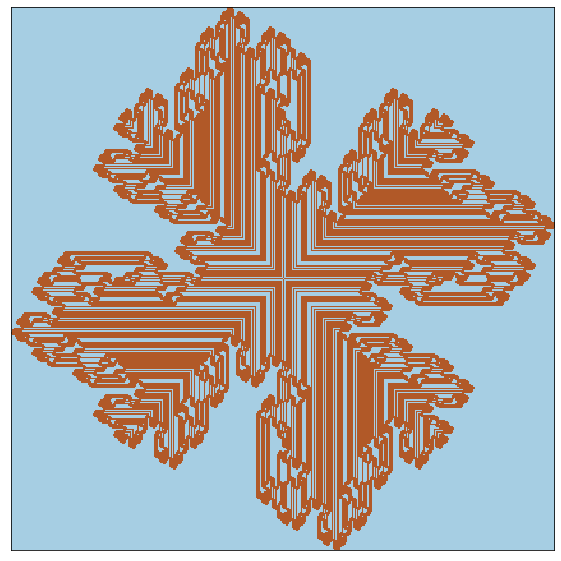

In [179]:
fig = plt.figure(figsize = (10,10))
plt.imshow(fractal2, cmap="Paired")
plt.xticks([])
plt.yticks([])
#plt.savefig(f"fractal_{4}_{0}.png")

## Set up the matrix

In [196]:
h = 1/max_idx
h

0.002347417840375587

In [197]:
n = max_idx**2 # number of unknowns

In [199]:
d = np.ones(n)